https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8138040/

https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7

In [133]:
import pandas as pd
import requests
from pandas.io.json import json_normalize
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

SIR disease model 

Surceptible, Infected, Recovered

S' (change in surceptible)= -beta * S * I
I' (change in infected)= (beta * S * I) - (nu * I)
R' (change in recivered)= nu * I

β (“beta”), the expected amount of people an infected person infects per day
If prob of infecting is 20% and a person meets 5 other people per day then 1 person per day is infected. 

The basic reproduction number R₀, the total number of people an infected person infects. if beta = 1, the Ro = 7 case that is the total number that an infected person infects. 

Gamma is the proportion recovery. If D is the number of days that and infected person has the disease, lets say it is 10 days and 50 people are infected then 1/10 * 50 will recover per day....so γ=1/10. With γ = 1/D, so D = 1/γ , and R₀ = β ⋅ D, it follows that R₀ = β / γ.

In [134]:
api_url = "https://api.coronavirus.data.gov.uk/v1/data?filters=areaType=nation;areaName=england"

In [135]:
params = {
         
    "date":"date",
    "areaName":"areaName",
    "areaCode":"areaCode",
     "newCasesByPublishDate": "newCasesByPublishDate",
     "newDeathsByDeathDate" : "newDeathsByDeathDate",
    "newPeopleReceivingFirstDose" : "newPeopleReceivingFirstDose",
    "cumCasesByPublishDate": "cumCasesByPublishDate",
    "cumDeathsByDeathDate": "cumDeathsByDeathDate",
    "cumPeopleVaccinatedFirstDoseByPublishDate": "cumPeopleVaccinatedFirstDoseByPublishDate"
}

In [136]:
response = requests.get(api_url, params=params)

In [137]:
data = response.json()

In [138]:
dict_items = data.items()

first_two = list(dict_items)[:2]
print(first_two)

[('response', 'An internal error occurred whilst processing your request, please try again. If the problem persists, please report as an issue and include your request.'), ('status_code', 500)]


In [139]:
print(data)

{'response': 'An internal error occurred whilst processing your request, please try again. If the problem persists, please report as an issue and include your request.', 'status_code': 500, 'status': 'Internal Server Error'}


TRY AGAIN WITH DIFFERENT URL 

In [140]:
api_url1="https://api.coronavirus.data.gov.uk/v1/data?filters=areaType=nation;areaName=england&"

In [141]:
params1 = {"date":"date","newCases":"newCasesByPublishDate"}

In [142]:
response1 = requests.get(api_url1, params=params1)

In [143]:
data1 = response1.json()

In [144]:
dict_items = data1.items()

first_two = list(dict_items)[:2]
print(first_two)

[('response', 'An internal error occurred whilst processing your request, please try again. If the problem persists, please report as an issue and include your request.'), ('status_code', 500)]


INDIAN COVID DATA FROM A DIFFERENT SOURCE AS ABOVE UK DATA HAS INTERNAL SERVER ERROR FOR UK.GOV WEBSITE

In [145]:
api_url2="https://api.covid19india.org/data.json"
response2 = requests.get(api_url2)
data2 = response2.json()


[('cases_time_series', [{'dailyconfirmed': '1', 'dailydeceased': '0', 'dailyrecovered': '0', 'date': '30 January 2020', 'dateymd': '2020-01-30', 'totalconfirmed': '1', 'totaldeceased': '0', 'totalrecovered': '0'}, {'dailyconfirmed': '0', 'dailydeceased': '0', 'dailyrecovered': '0', 'date': '31 January 2020', 'dateymd': '2020-01-31', 'totalconfirmed': '1', 'totaldeceased': '0', 'totalrecovered': '0'}, {'dailyconfirmed': '0', 'dailydeceased': '0', 'dailyrecovered': '0', 'date': '1 February 2020', 'dateymd': '2020-02-01', 'totalconfirmed': '1', 'totaldeceased': '0', 'totalrecovered': '0'}, {'dailyconfirmed': '1', 'dailydeceased': '0', 'dailyrecovered': '0', 'date': '2 February 2020', 'dateymd': '2020-02-02', 'totalconfirmed': '2', 'totaldeceased': '0', 'totalrecovered': '0'}, {'dailyconfirmed': '1', 'dailydeceased': '0', 'dailyrecovered': '0', 'date': '3 February 2020', 'dateymd': '2020-02-03', 'totalconfirmed': '3', 'totaldeceased': '0', 'totalrecovered': '0'}, {'dailyconfirmed': '0', 'd

In [146]:
time_series_of_cases=pd.DataFrame(data2['cases_time_series'])
print(time_series_of_cases.head())

  dailyconfirmed dailydeceased dailyrecovered             date     dateymd  \
0              1             0              0  30 January 2020  2020-01-30   
1              0             0              0  31 January 2020  2020-01-31   
2              0             0              0  1 February 2020  2020-02-01   
3              1             0              0  2 February 2020  2020-02-02   
4              1             0              0  3 February 2020  2020-02-03   

  totalconfirmed totaldeceased totalrecovered  
0              1             0              0  
1              1             0              0  
2              1             0              0  
3              2             0              0  
4              3             0              0  


In [147]:
tested=pd.DataFrame(data2['tested'])
print(tested.head())

  dailyrtpcrsamplescollectedicmrapplication firstdoseadministered  \
0                                                                   
1                                                                   
2                                                                   
3                                                                   
4                                                                   

  frontlineworkersvaccinated1stdose frontlineworkersvaccinated2nddose  \
0                                                                       
1                                                                       
2                                                                       
3                                                                       
4                                                                       

  healthcareworkersvaccinated1stdose healthcareworkersvaccinated2nddose  \
0                                                                      

In [148]:
splitval = int(len(time_series_of_cases) * 0.75)

In [149]:
train=time_series_of_cases[0:splitval]
test=time_series_of_cases[splitval+1:]

EXPLORING SIR MODEL

BELOW IS AN SIR MODEL OF HEARING A RUMOUR AT SCHOOL. 
SURCEPTIBLE, INFECTED. IN THIS MODEL R IS WHEN THE STUDENTS BECOME BORED OF THE RUMOUR SO ARE REMOVED FROM BEING INFECTED AND NO LONGER SURCEPTIBLE. 

gamma = proportion of infected(those that have heard the rumour) that are now bored of it so no longer infected or surceptible. 
t = time 
number that know the rumour at 'time'
beta =dsc averae daily nuber of contacts *p probability of hearing the rumour if in contact 
N = population  

In [160]:
def rumour(y, t, N, beta, gamma):
    S, I, R= y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [161]:
N = 1000
beta = 4  # hat number of other people tha 1 person tells the rumour to per day
D = 4.0 # interest in rumour (infection) lasts four days
gamma = 1.0 / D

S0, I0, R0 = 999, 1, 0  # initial conditions: one person knows the rumour, rest are susceptible

In [162]:
t = np.linspace(0, 49, 50) # start, finish and number of time points (in days)

y0 = S0, I0, R0 # Initial conditions vector

# Integrate the SI equations over the time grid, t.
ret = odeint(rumour, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

In [165]:

def plotsir(t, S, I, R):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, I, 'y', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

  ax.set_xlabel('Time (days)')
  
  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  
  legend = ax.legend()
  legend.get_frame().set_alpha(0.5)
  
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  
plt.show();

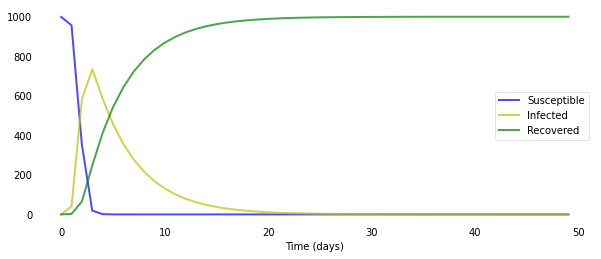

In [164]:
plotsir(t, S, I, R)